In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import Library

from pyclustering.cluster import cluster_visualizer, cluster_visualizer_multidim
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.fcm import fcm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

## <hr><center>Load the datasets cleaned by the Task 1 Notebook</center><hr>

In [ ]:
players_df = pd.read_csv('../data_cleaned/players.csv')
print(f'(players_df) Loading {players_df.shape[0]} rows from "../data_cleaned/players_df.csv"')

matches_df = pd.read_csv('../data_cleaned/matches_side.csv')
print(f'(matches_side_df) Loading {matches_df.shape[0]} rows from "../data_cleaned/matches_side_df.csv"')

players_statistics    = Library.deserialize_statistics('data/players_df.stat')
match_side_statistics = Library.deserialize_statistics('data/match_side_df.stat')

(players_df) Loading 1918 rows from "../data_cleaned/players_df.csv"
(matches_side_df) Loading 370946 rows from "../data_cleaned/matches_side_df.csv"


## <hr><center>Fuzzy C-Means Clustering</center><hr>

In [ ]:
# Consider the clustering attributes we searched and selected for the task.
clustering_attributes = ['avg_ace%', 'avg_df%', 'avg_1st%', 'avg_bpSaved%', 'win_rate', 'rank_points']

# Normalize the resulting data using StandardScaler.
scaler = StandardScaler()
numerical_attributes = Library.numerical_attributes(players_statistics)
norm_players_df = pd.DataFrame(scaler.fit_transform(players_df[numerical_attributes]), columns=numerical_attributes)
clustering_players_df = norm_players_df[clustering_attributes]

In [ ]:
# FCM uses a different method to represent the cluster results.
# We use this function to convert them back to the original format used throughout the project. 
def get_players_label(df, clusters):
    fcm_labels = np.zeros(df.shape[0])
    for cluster_label, rows in enumerate(clusters):
        for row in rows:
            fcm_labels[row] = cluster_label
    return fcm_labels

k_values = [3, 4, 5, 6, 7, 8, 9, 10]     # Number of clusters
m_values = [1.1, 1.5, 2, 2.5, 3, 3.5, 4] # Cluster fuzziness
data = []

# Convert the data to numpy to accomodate the FCM methods.
sample = clustering_players_df.to_numpy()

# Run FCM for each combination of k and m.
for m in m_values:
    for k in k_values:
        # Initialize the centroid using kmeans++.
        initial_centers = kmeans_plusplus_initializer(
            sample, k, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE
        ).initialize()

        # Create instance of Fuzzy C-Means algorithm.
        fcm_instance = fcm(sample, initial_centers, m=m)

        # Run cluster analysis and obtain the results.
        fcm_instance.process()
        clusters = fcm_instance.get_clusters()

        # Assign label to each player.
        players_df['fcmLabel'] = get_players_label(players_df, clusters)

        # Get result and assign the label to the data.
        (unique, counts) = np.unique(players_df['fcmLabel'], return_counts=True)
        sil = silhouette_score(clustering_players_df, players_df['fcmLabel'])
        dbs = davies_bouldin_score(clustering_players_df, players_df['fcmLabel'])
        data.append([k, m, sil, dbs, unique.shape[0]])

# Finally, compute the average silhouette score and Davies-Bouldin score.
fcm_result_df = pd.DataFrame(data, columns=['k', 'm', 'sil', 'dbs', 'n_cluster'])

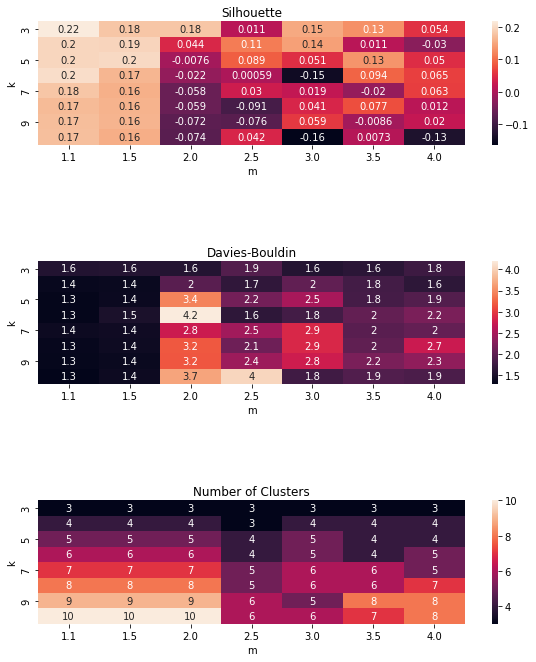

In [ ]:
# Display the results using heatmaps for the various combinations of the parameters.
 
fig, axs = plt.subplots(nrows=3)

sb.heatmap(fcm_result_df.pivot(index='k', columns='m', values='sil'), annot=True, ax=axs[0])
axs[0].set_title('Silhouette', pad=5)

sb.heatmap(fcm_result_df.pivot(index='k', columns='m', values='dbs'), annot=True, ax=axs[1])
axs[1].set_title('Davies-Bouldin', pad=5)

sb.heatmap(fcm_result_df.pivot(index='k', columns='m', values='n_cluster'), annot=True, ax=axs[2])
axs[2].set_title('Number of Clusters', pad=5)

fig.tight_layout(pad=0.05)
plt.gcf().set_size_inches(8, 10)

In [ ]:
# We then sort the results by Silhouette value.
fcm_result_df.sort_values(by=['sil'], ascending=False)

,k,m,sil,dbs,n_cluster
0,3,1.1,0.217568,1.555491,3
3,6,1.1,0.203749,1.316453,6
10,5,1.5,0.199583,1.378561,5
2,5,1.1,0.196096,1.319450,5
1,4,1.1,0.195377,1.351301,4
9,4,1.5,0.194801,1.359666,4
8,3,1.5,0.180401,1.569111,3
4,7,1.1,0.179688,1.389766,7
16,3,2.0,0.179217,1.564024,3
7,10,1.1,0.173760,1.290411,10


In [ ]:
# We report here the final clustering results.
# Top 3 silhouette models are:
#   - (k=3, m=1.1)
#   - (k=6, m=1.1)
#   - (k=5, m=1.5)

k = 5
m = 1.5

# Reinitialize the cluster models with the selected parameters.
initial_centers = kmeans_plusplus_initializer(
    sample, k, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE
).initialize()

# Again, view the clustersing results.
fcm_instance = fcm(sample, initial_centers, m=m)
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

0.0    641
1.0    531
2.0    364
3.0    306
4.0     76
Name: fcmLabel, dtype: int64


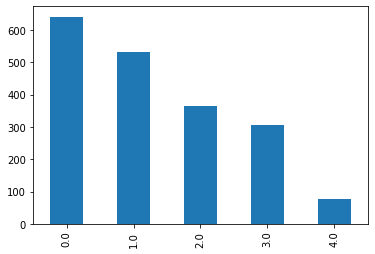

In [ ]:
# Consider the clustering sizes and reorder them by size.

players_df['fcmLabel'] = get_players_label(players_df, clusters)
Library.reorder_clusters(players_df, 'fcmLabel')
plt.gcf().set_size_inches(6, 4)
players_df['fcmLabel'].value_counts().sort_index().plot(kind='bar')
#Library.save('fcm_cluster_sizes.svg')
print(players_df['fcmLabel'].value_counts())

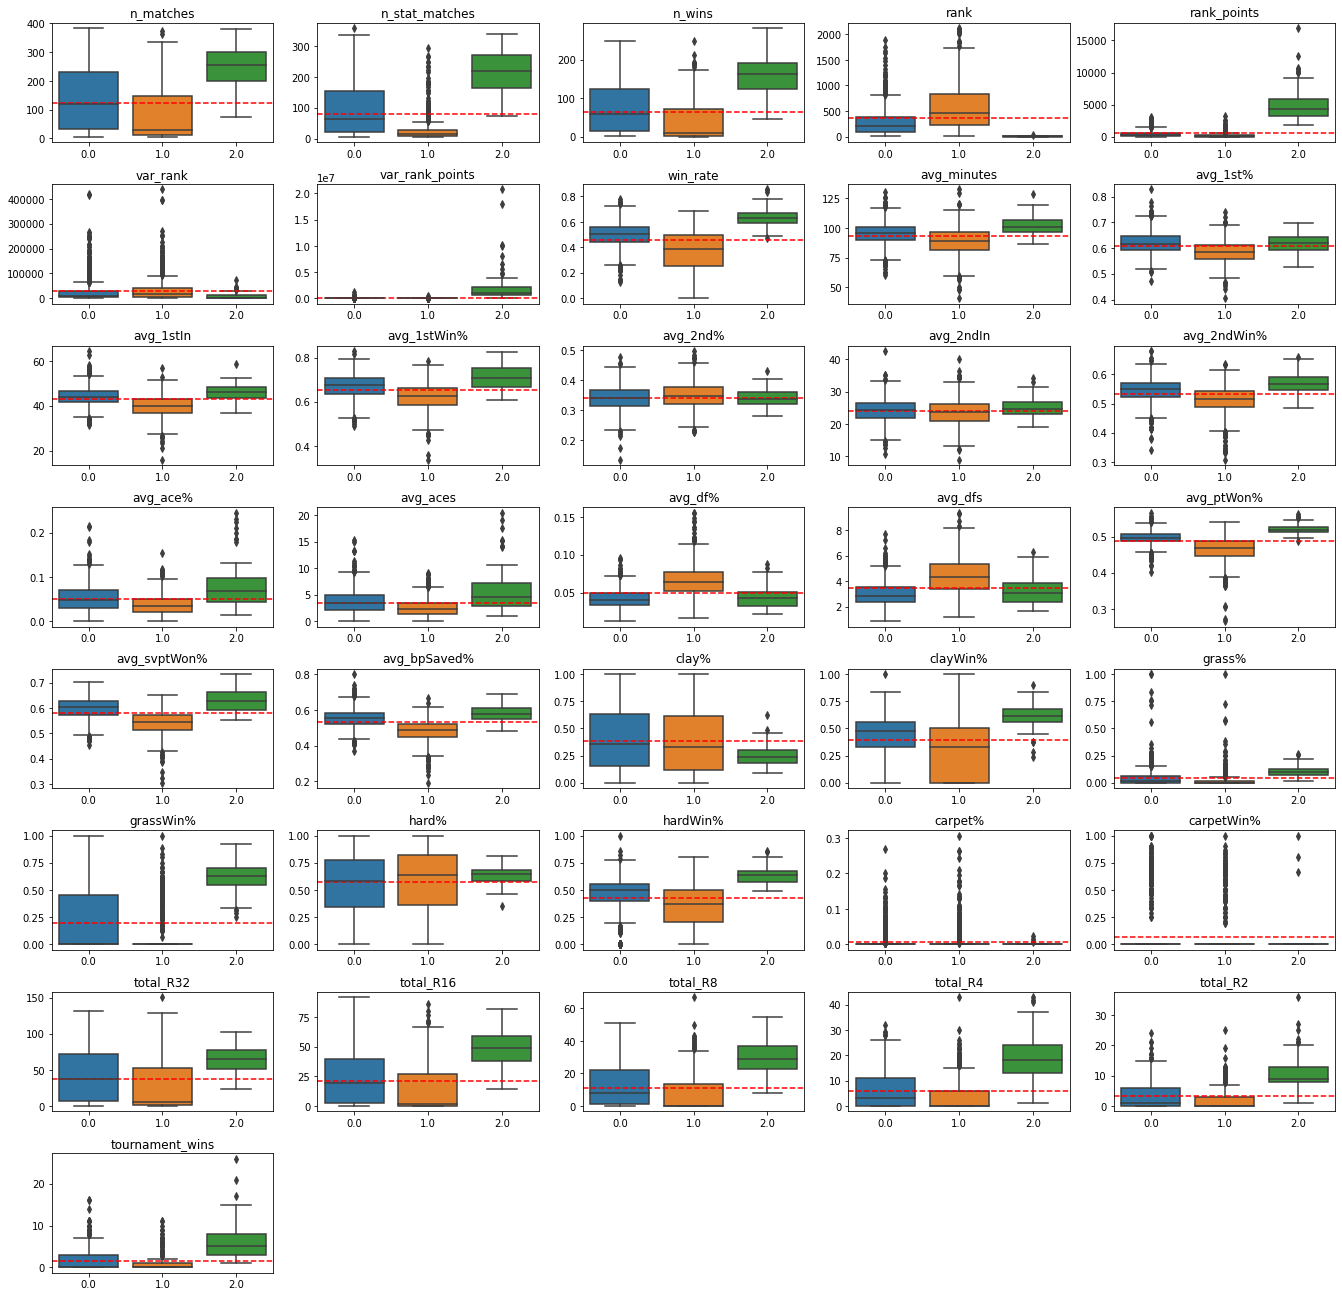

In [ ]:
# Plot the cluster statistics with the custom Library function.

plt.gcf().set_size_inches(23, 23)
plt.gcf().tight_layout() 
plt.subplots_adjust(hspace=0.35)   
Library.plot_clusters(players_statistics, players_df, 'fcmLabel')